In [1]:
import torch
import sys
from fcn import FCN

In [2]:
# torch_model = torch.load("./bestModels/fcn.pt", map_location="cpu")
model = torch.load("./bestModelFinal.pt", map_location=torch.device("cpu"))

In [3]:
torch_input = torch.randn(1, 640, 640, 3)
traced_model = torch.jit.trace(model, torch_input)

In [4]:
torch.onnx.export(traced_model, torch_input, "fcn.onnx")

/home/charbel/.local/lib/python3.11/site-packages/torch/onnx/utils.py:847: UserWarning: no signature found for builtin <built-in method __call__ of PyCapsule object at 0x7f2cc1548150>, skipping _decide_input_format
  warnings.warn(f"{e}, skipping _decide_input_format")
/home/charbel/.local/lib/python3.11/site-packages/torch/onnx/symbolic_helper.py:1515: UserWarning: ONNX export mode is set to TrainingMode.EVAL, but operator 'batch_norm' is set to train=True. Exporting with train=True.
  warnings.warn(


In [ ]:
!netron  fcn.onnx

In [ ]:
onnx_program = torch.onnx.dynamo_export(model, torch_input)

In [5]:
onnx_program.save("fcn.onnx")

In [130]:
import onnxruntime as ort
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt

# Load the ONNX model
session = ort.InferenceSession("./my_image_classifier.onnx")

In [131]:
from PIL import Image

image = Image.open("./fcn/fcn_data/images/rgb_0000.png")

In [132]:
input_name = session.get_inputs()[0].name

In [133]:
image = torch.tensor(np.expand_dims(np.array(image), axis=0), dtype=torch.float32)

In [134]:
image.shape

torch.Size([1, 720, 1280, 3])

In [135]:
import torchvision.transforms as transforms

resize = transforms.Resize((640, 640))

In [136]:
import torchvision.transforms as transforms

resize = transforms.Resize((640, 640))
image = image.permute(0, 3, 2, 1)
image = resize(image)
image = image.permute(0, 3, 2, 1) / 255

In [137]:
image.shape

torch.Size([1, 640, 640, 3])

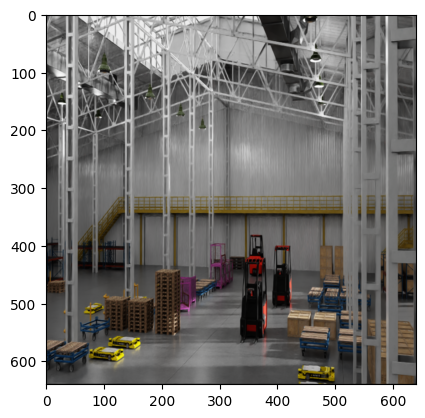

In [139]:
# Measure inference time with ONNX Runtime
start_time = time.time()
outputs = session.run(None, {input_name: np.array(image)})
end_time = time.time()
print("ONNX Inference Time:", end_time - start_time)

ONNX Inference Time: 2.7579967975616455


In [140]:
torch.tensor(outputs[0][0]).permute(2, 1, 0).shape

torch.Size([640, 640, 10])

In [141]:

image = torch.tensor(outputs[0][0]).permute(1, 2, 0)

In [142]:
image.shape

torch.Size([640, 640, 10])

torch.Size([1, 640, 640, 10])

In [144]:

image = torch.tensor(np.expand_dims(np.array(image), axis=0))

In [145]:
color_map = torch.tensor(
    [
        [0, 0, 0],
        [25, 82, 255],
        [255, 25, 197],
        [140, 255, 25],
        [0, 0, 0],
        [226, 255, 25],
        [255, 197, 25],
        [140, 25, 255],
        [54, 255, 25],
        [25, 255, 82],
        [255, 111, 25],
    ]
)


def map_one_hot_to_image(one_hot, color_map):
    batch_size, height, width, num_colors = one_hot.shape

    # Use argmax to find the index of the 1 in each one-hot vector
    indices = torch.argmax(one_hot, dim=-1)

    # Use the indices to select colors from the color map
    output = color_map[indices]

    return output

In [146]:
image = map_one_hot_to_image(image, color_map)

torch.Size([1, 640, 640, 3])

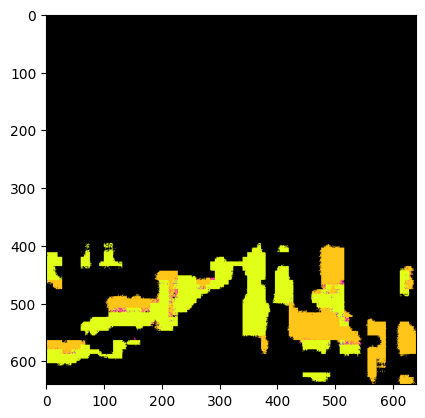

In [148]:
import matplotlib.pyplot as plt

plt.imshow(np.array(image)[0])